In [5]:
import datetime
import sklearn
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import KernelPCA
import numpy as np
import pandas as pd
import math
import tensorflow as tf
import matplotlib.pyplot as plt
tf.random.set_seed(99)

In [6]:
# Dataset loading
url = 'https://raw.githubusercontent.com/SusmitSekharBhakta/Stock-market-price-prediction/main/final_data_adj.csv'

dataFrame = pd.read_csv(url) 
print(dataFrame.head())


         Date         Open         High          Low        Close  \
0  2017-08-28  9907.150391  9925.750000  9882.000000  9912.799805   
1  2017-08-29  9886.400391  9887.349609  9783.750000  9796.049805   
2  2017-08-30  9859.500000  9909.450195  9850.799805  9884.400391   
3  2017-08-31  9905.700195  9925.099609  9856.950195  9917.900391   
4  2017-09-01  9937.650391  9983.450195  9909.849609  9974.400391   

     Adj Close    Volume        RSI       MACD    MACDsig  MACDhist  \
0  9912.799805  159600.0  55.406997  28.647258  28.317577  0.515867   
1  9796.049805  173300.0  55.406997  28.647258  28.317577  0.515867   
2  9884.400391  157800.0  55.406997  28.647258  28.317577  0.515867   
3  9917.900391  327700.0  55.406997  28.647258  28.317577  0.515867   
4  9974.400391  157800.0  55.406997  28.647258  28.317577  0.515867   

            SMA        CCI  Aroon Up  Aroon Down         Sadj  
0  12759.905212  24.363507       0.0         0.0          NaN  
1  12759.905212  24.363507    

In [7]:
imputer = SimpleImputer(missing_values=np.nan)
dataFrame.drop(columns=['Date'], inplace=True)
dataFrame = pd.DataFrame(imputer.fit_transform(
	dataFrame), columns=dataFrame.columns)
dataFrame = dataFrame.reset_index(drop=True)
# Applying feature scaling
scaler = MinMaxScaler(feature_range=(0, 1))
df_scaled = scaler.fit_transform(dataFrame.to_numpy())
df_scaled = pd.DataFrame(df_scaled, columns=list(dataFrame.columns))

target_scaler = MinMaxScaler(feature_range=(0, 1))

df_scaled[['Open', 'Close']] = target_scaler.fit_transform(
	dataFrame[['Open', 'Close']].to_numpy())

df_scaled = df_scaled.astype(float)
print(df_scaled.head())


       Open      High       Low     Close  Adj Close    Volume       RSI  \
0  0.199868  0.178737  0.216833  0.211888   0.211888  0.088128  0.573174   
1  0.197958  0.175103  0.207848  0.201145   0.201145  0.095693  0.573174   
2  0.195483  0.177194  0.213980  0.209275   0.209275  0.087134  0.573174   
3  0.199734  0.178675  0.214542  0.212358   0.212358  0.180950  0.573174   
4  0.202674  0.184197  0.219380  0.217557   0.217557  0.087134  0.573174   

       MACD   MACDsig  MACDhist       SMA       CCI  Aroon Up  Aroon Down  \
0  0.753954  0.738291  0.504494  0.441765  0.541449       0.0         0.0   
1  0.753954  0.738291  0.504494  0.441765  0.541449       0.0         0.0   
2  0.753954  0.738291  0.504494  0.441765  0.541449       0.0         0.0   
3  0.753954  0.738291  0.504494  0.441765  0.541449       0.0         0.0   
4  0.753954  0.738291  0.504494  0.441765  0.541449       0.0         0.0   

       Sadj  
0  0.172391  
1  0.167173  
2  0.166825  
3  0.166850  
4  0.17676

In [8]:
# Single step dataset preparation
def singleStepSampler(df, window):
    xRes = []
    yRes = []
    for i in range(0, len(df) - window):
        res = []
        for j in range(0, window):
            r = []
            for col in df.columns:
                r.append(df[col][i + j])
            res.append(r)
        xRes.append(res)
        yRes.append(df[['Open', 'Close']].iloc[i + window].values)
    return np.array(xRes), np.array(yRes)

# Assuming df_scaled is defined elsewhere
(xVal, yVal) = singleStepSampler(df_scaled, 20)

In [9]:
# Dataset splitting
SPLIT = 0.85

X_train = xVal[:int(SPLIT * len(xVal))]
y_train = yVal[:int(SPLIT * len(yVal))]
X_test = xVal[int(SPLIT * len(xVal)):]
y_test = yVal[int(SPLIT * len(yVal)):]

In [10]:
# Build RNN model
rnn_model = tf.keras.Sequential()
rnn_model.add(
    tf.keras.layers.SimpleRNN(200, input_shape=(X_train.shape[1], X_train.shape[2])))
rnn_model.add(
    tf.keras.layers.Dropout(0.5))

# Output layer for two predictor variables
rnn_model.add(
    tf.keras.layers.Dense(2, activation='linear'))

# Compile the model
rnn_model.compile(loss='MeanSquaredError',
                   metrics=['MAE', 'MSE'],
                   optimizer=tf.keras.optimizers.Adam())
rnn_model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 200)               43200     
                                                                 
 dropout (Dropout)           (None, 200)               0         
                                                                 
 dense (Dense)               (None, 2)                 402       
                                                                 
Total params: 43602 (170.32 KB)
Trainable params: 43602 (170.32 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [11]:
# Train the model
history = rnn_model.fit(X_train, y_train, epochs=20)

Epoch 1/20


48/48 [==============================] - 1s 4ms/step - loss: 0.1832 - MAE: 0.3152 - MSE: 0.1832
Epoch 2/20
48/48 [==============================] - 0s 4ms/step - loss: 0.0410 - MAE: 0.1587 - MSE: 0.0410
Epoch 3/20
48/48 [==============================] - 0s 4ms/step - loss: 0.0265 - MAE: 0.1287 - MSE: 0.0265
Epoch 4/20
48/48 [==============================] - 0s 4ms/step - loss: 0.0190 - MAE: 0.1091 - MSE: 0.0190
Epoch 5/20
48/48 [==============================] - 0s 4ms/step - loss: 0.0158 - MAE: 0.0987 - MSE: 0.0158
Epoch 6/20
48/48 [==============================] - 0s 4ms/step - loss: 0.0133 - MAE: 0.0899 - MSE: 0.0133
Epoch 7/20
48/48 [==============================] - 0s 4ms/step - loss: 0.0112 - MAE: 0.0837 - MSE: 0.0112
Epoch 8/20
48/48 [==============================] - 0s 4ms/step - loss: 0.0106 - MAE: 0.0805 - MSE: 0.0106
Epoch 9/20
48/48 [==============================] - 0s 4ms/step - loss: 0.0093 - MAE: 0.0755 - MSE: 0.0093
Epoch 10/20
48/48 [================

In [12]:
# Forecast Plot
predicted_values = rnn_model.predict(X_test)

d = {
    'Predicted_Open': predicted_values[:, 0],
    'Predicted_Close': predicted_values[:, 1],
    'Actual_Open': y_test[:, 0],
    'Actual_Close': y_test[:, 1],
}

d = pd.DataFrame(d)

9/9 [==============================] - 0s 2ms/step


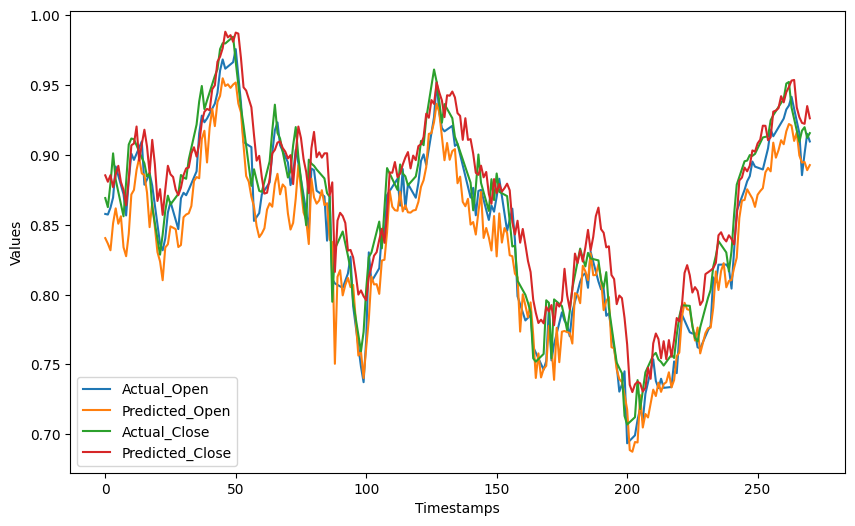

In [13]:
fig, ax = plt.subplots(figsize=(10, 6))
plt.plot(d[['Actual_Open', 'Predicted_Open']], label=['Actual_Open', 'Predicted_Open'])
plt.plot(d[['Actual_Close', 'Predicted_Close']], label=['Actual_Close', 'Predicted_Close'])
plt.xlabel('Timestamps')
plt.ylabel('Values')
ax.legend()
plt.show()

In [14]:
# Model Evaluation
def eval(model):
    return {
        'MSE': sklearn.metrics.mean_squared_error(d[f'Actual_{model.split("_")[1]}'].to_numpy(), d[model].to_numpy()),
        'MAE': sklearn.metrics.mean_absolute_error(d[f'Actual_{model.split("_")[1]}'].to_numpy(), d[model].to_numpy()),
        'R2': sklearn.metrics.r2_score(d[f'Actual_{model.split("_")[1]}'].to_numpy(), d[model].to_numpy())
    }

result = dict()

for item in ['Predicted_Open', 'Predicted_Close']:
    result[item] = eval(item)

result


{'Predicted_Open': {'MSE': 0.0003255399611099331,
  'MAE': 0.014763707952958631,
  'R2': 0.9209973256947335},
 'Predicted_Close': {'MSE': 0.00046937799068089587,
  'MAE': 0.016822231923897462,
  'R2': 0.8844339062130968}}

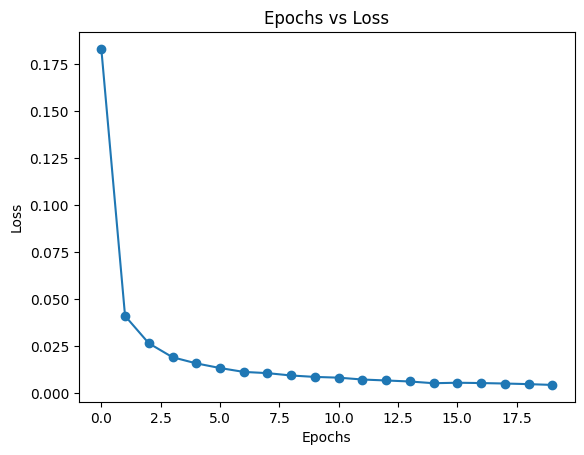

In [15]:
import matplotlib.pyplot as plt

# Plot epochs vs loss
plt.plot(history.history['loss'], marker='o')
plt.title('Epochs vs Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()